In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import IPython
import pyroomacoustics as pra

(-0.1, 1.2)

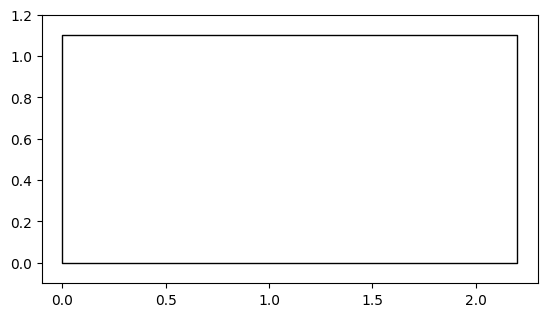

In [2]:
# 创建二维房间节点 （顺时针旋转）
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 由二维空间节点构建二维房间
room = pra.Room.from_corners(corners)

# 绘制二维房间
fig, ax = room.plot()
ax.set_xlim([-0.1, 2.3])
ax.set_ylim([-0.1, 1.2])

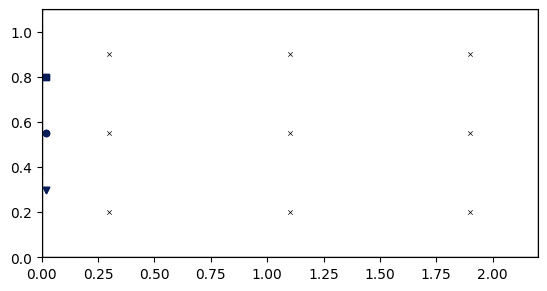

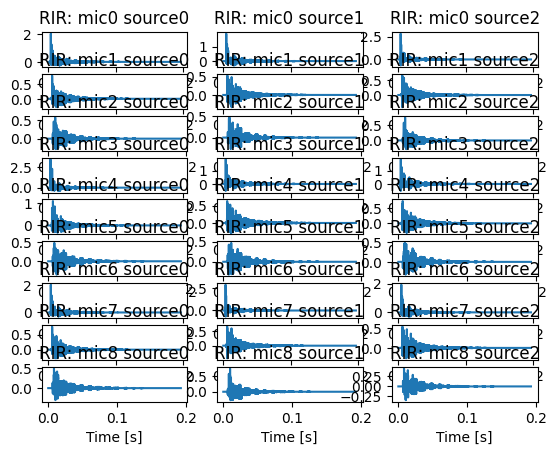

In [71]:
# 原始噪声信号
fs, signal = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率（air_absorption），最大阶数（max_order）、材料（materials）参数进行设置，并生成新的 2D 房间 room 对象
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 使用 add_source() 方法在 [0.02, 0.55], [0.02, 0.8], [0.02, 0.3] 三处添加信号源 signal
room.add_source([0.02, 0.55], signal=signal)
room.add_source([0.02, 0.8], signal=signal)
room.add_source([0.02, 0.3], signal=signal)

# 下面在房子中心添加一个误差麦克风
# room.add_microphone([1.1, 0.55], fs)

# 下面在房间中添加麦克风阵列，用于接收房间内的分布是噪声分布情况：
# R = np.array([[0.2, 0.8, 1.4, 2.0, 0.2, 0.8, 1.4, 2.0, 0.2, 0.8, 1.4, 2.0,], [0.2, 0.2, 0.2, 0.2, 0.55, 0.55, 0.55, 0.55, 0.9, 0.9, 0.9, 0.9]])

R = np.array([[0.3, 1.1, 1.9, 0.3, 1.1, 1.9, 0.3, 1.1, 1.9], [0.2, 0.2, 0.2,0.55, 0.55, 0.55, 0.9, 0.9, 0.9]])

room.add_microphone(R)

# 使用 image_source_model() 类方法计算房间 room 的麦克风脉冲响应
room.image_source_model()

# 绘制房间
fig, ax = room.plot()

# 使用 room 的 plot_rir() 类方法绘制麦克风的 RIR
room.plot_rir()

# 在使用 `image_source_model()` 方法计算了房间的脉冲响应后，我们就可以说使用信号与这些脉冲响应进行卷积即可得到房间的信号仿真
room.simulate()

查看 `room.rir` 的数据结构：

In [28]:
print(type(room.rir))
print(dir(room.rir))
print(dir(room))

<class 'list'>
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_init_room_engine', '_set_ray_tracing_options', '_update_room_engine_params'

In [47]:
print(type(room.mic_array))
print(dir(room.mic_array))
print(len(room.mic_array))

<class 'pyroomacoustics.beamforming.MicrophoneArray'>
['M', 'R', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'append', 'center', 'dim', 'directivity', 'fs', 'nmic', 'record', 'set_directivity', 'signals', 'to_wav']
9


下面的查看分布麦克风的仿真效果：

In [44]:
# 原始噪声信号
print("Original Wave:")
IPython.display.Audio(signal, rate=fs)

Original Wave:


In [46]:
IPython.display.Audio(room.mic_array.signals[8, :], rate=fs)

In [50]:
print(room.mic_array.signals.shape)

(9, 963152)


下面设计基于 GA 的第二通道的信号生成方法。

In [39]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, elementwise=True, **kwargs):
        super().__init__(
            n_var=3,
            n_obj=9
        )

    def _evaluate(self, x, out, *args, **kwargs):

        f1 = room.add_source([0.02, 1.08], signal=x[0]) + room.add_source([2.18, 1.08], signal=x[1]) + room.add_source([2.18, 0.02], signal=x[2]) + room.add_source([0.02, 0.02], signal=x[3])

In [67]:
def room_sim_fun(i, signal):
    room.add_source([0.02, 0.55], signal=signal[i])
    room.image_source_model()   # 得到房间的 RIR
    room.simulate()             # 为了得到麦克风的信号

    